In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import xgboost as xgb

## Input data

In [2]:
dfFull = pd.read_csv('../Dataset/full_feature.csv')
dfFull.dropna(inplace=True)
dfFull.head(2)

originalRate  size  starRating  AIR_CONDITIONING  BALCONY_TERRACE  \
0       1227273  46.0         4.0               1.0              1.0   
1        596694  31.0         4.0               1.0              0.0   

   BATHROBES  BATHTUB  BLACKOUT_DRAPES_CURTAINS  COFFEE_TEA_MAKER  \
0        1.0      1.0                       1.0               1.0   
1        1.0      1.0                       1.0               1.0   

   COMPLIMENTARY_BOTTLED_WATER  ...  PARK  HOSPITAL  MUSEUM  GALLERY  \
0                          1.0  ...   0.0       0.0     0.0      0.0   
1                          1.0  ...   0.0       0.0     0.0      0.0   

   PLACE_OF_WORSHIP  TRAIN_STATION  ZOO  ENTERTAINMENT  GARDEN.1  THEATER  
0               0.0            0.0  0.0            0.0       0.0      0.0  
1               0.0            0.0  0.0            0.0       0.0      0.0  

[2 rows x 294 columns]

In [3]:
X = dfFull.drop('originalRate', axis=1)
y = dfFull['originalRate']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4382, 293) (487, 293) (4382,) (487,)


In [5]:
# sc = StandardScaler()

# # Standardize the training dataset
# X_train_transform = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# # Standardized the testing dataset
# X_test_transform = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# # Summary statistics after standardization
# X_train_transform.describe()

In [6]:
# X_train.describe()

In [7]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV

# Train the model with XGBoost
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror',
    eval_metric='rmse'
    )
parameters = {
    'colsample_bytree': [0.8],# 0.8
    # 'gamma': [0], # 0.0
    'learning_rate': [0.01], # 0.01
    'max_depth': [50], # 50
    'min_child_weight': [3], # 3
    'n_estimators': [350], # 400
    # 'reg_alpha': [0,5], # 5.0
    # 'reg_lambda': [0], # 5.0
    'subsample': [0.7], # 0.7
    # 'random_state': [42], # 42
    # 'scale_pos_weight': [1], # 1
    # 'max_delta_step': [1],
}
# Set up score
scoring = ['neg_root_mean_squared_error', 'r2']

# Set up the k-fold cross-validation
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


In [8]:
grid = GridSearchCV(
    xg_reg,
    parameters,
    scoring=scoring,
    cv=3,
    refit='r2',
    n_jobs=-1,
    verbose=3
    )
result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [9]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid.best_score_:.4f}')
# print(f'The best hyperparameters are {grid.best_params_}')

The best score is 0.6582


In [10]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=350, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [11]:
grid.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 50,
 'min_child_weight': 3,
 'n_estimators': 350,
 'subsample': 0.7}

In [12]:
print('Train evaluation')
preds = grid.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
# print('MAE: ', '{0:,.0f}'.format(mean_absolute_error(y_train, preds)))
# print('MSE: ', '{0:,.0f}'.format(mse))
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds),3))
print('-'*20)

print('Test evaluation')
preds = grid.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
# print('MAE: ', '{0:,.0f}'.format(mean_absolute_error(y_test, preds)))
# print('MSE: ', '{0:,.0f}'.format(mse))
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_test, preds),3))

Train evaluation
RMSE:  985,932
R2:  0.929
--------------------
Test evaluation
RMSE:  1,934,160
R2:  0.776


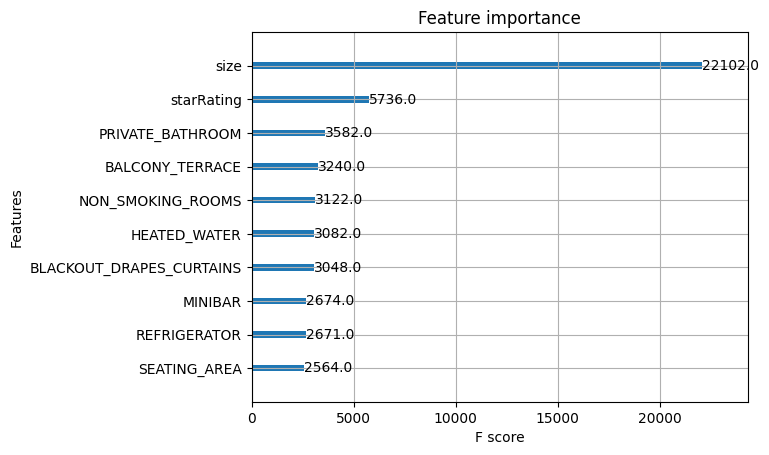

In [13]:
xgb.plot_importance(grid.best_estimator_, max_num_features=10)
plt.savefig('feature_importance.png', dpi=300)

In [14]:
from xgboost import plot_tree

plot_tree(grid.best_estimator_, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig('tree.png')